In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

In [2]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

# 条件付け

* 確率的プログラミングの真の力は、生成モデルを観測値で条件付け、そのデータを生成しうる潜在変数の推論するという能力にある
* Pyro の API には、生成モデルの定義と条件付けを分離させることで、何回でもデータに対して条件付ける操作を行えるような工夫が施されている

`scale` をもう一度考える

* `guess = 8.5` に対する `weight` の分布は、`measurement == 9.5` が観測されていた場合どうなるだろうか？
* つまり次の分布を推論したい

$$
P(weight|guess, measurement=9.5)
$$

* Pyro では `pyro.condition` を使ってデータの条件付けを行う
* `pyro.condition` は高階関数
    * モデルと観測値を入力する
    * 出力はモデルと一緒の外見だが、データで条件付けられたモデル

In [3]:
conditioned_scale = pyro.condition(scale, data={'measurement': 9.5})

任意の Python の関数のように振る舞うので、`lambda` や `def` のように遅延させることも出来ます。

In [4]:
def deffered_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={'measurement': measurement})(*args, **kwargs)

条件付けをモデル定義に盛り込むこともできる

* `pyro.sample` のキーワード引数として `obs` を追加すれば良い
* この操作は後で `pyro.condition` するのと等価

In [5]:
def scale_obs(guess):
    # conditioned_scale と等価
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    return pyro.sample("measurement", dist.Normal(weight, 1.), obs=9.5)

観測値をモデルに組み込む違う方法として、`pyro.do` というものがある。
- これは、Pearl の do-operator の実装であり、因果モデルの観測値に対応する。
- `pyro.do` と `pyro.condition` は自由にミックスさせて使うことが出来る。

## ガイド関数による柔軟な近似推論

In [6]:
def perfect_quide(guess):
    loc = (0.75**2 * guess + 9.5) / (1 + 0.75**2)
    scale = np.sqrt(0.75**2/(1+0.75**2))
    return pyro.sample("weight", dist.Normal(loc, scale))

## パラメトリックな確率的関数と変分推論

- `scale` に対する完全な事後分布を書き出すことは出来ますが、一般に、条件付けられた任意の確率的関数の事後分布の良い近似をもたらすガイドを指定するのは不可能です。
- 実際、我々が真の事後分布を正確に知ることができる確率的関数は寧ろ例外的な存在です。
- 例えば、`scale` の例で考えると、中間の処理を非線形関数に置き換えたバージョンのものは、取扱いが出来ません。

In [7]:
def intractable_scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    mean = some_nonlinear_func(weight)
    return pyro.sample("measurement", dist.Normal(mean, 0.75))

- この場合、抽象度の高い関数 `pyro.param` を使って、特定の名前のパラメータによって索引付けられるガイドの*族*を指定することしか出来ません。
- そして、ある損失関数の下で、最も近似性能がよいその属のモデルを探索します。
- 事後分布を近似するこのアプローチは**変分推論**と呼ばれます。

`pyro.param` は

In [9]:
simple_param_store = {}
a = simple_param_store.setdefault("a", torch.randn(1))

例えば、直接指定するのではなく、`scale_posterior_guide` の `a` と `b` をパラメタライズできます。

In [10]:
def scale_parameterized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

余談ではありますが、`scale_parameterized_guide` の内容をよく見てみましょう。ガウス分布の標準偏差は正であることが要請される為、パラメータ `b` に `torch.abs` を適用しなくてはなりません。

Pyro は PyTorch に基づいたライブラリですが、PyTorch の確率分布ライブラリには、上のような制約を満たす為のモジュール (constraints module) が含まれています。
Pyro でのパラメータが制約モジュールを使って自動的に制約を満たすようにするには、`pyro.param` に関連する `constraint` オブジェクトを渡してください。

In [11]:
from torch.distributions import constraints

def scale_parameterized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))

In [12]:
guess = torch.tensor(8.5)

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                    guide=scale_parameterized_guide,
                    optim=pyro.optim.SGD({
                        'lr': 0.001,
                        "momentum": 0.1
                    }),
                    loss=pyro.infer.Trace_ELBO())

losses, a, b = [], [], []
n_steps = 2500

for t in range(n_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())


/home/openjny/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


a =  9.110149383544922
b =  0.6260182857513428


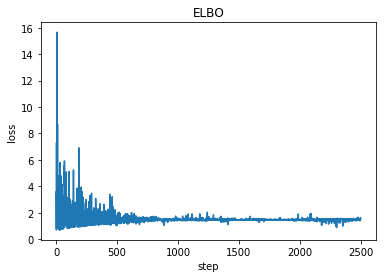

In [13]:
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
print('a = ', pyro.param("a").item())
print('b = ', pyro.param("b").item())